### Phase contrast imaging of twisted bilayer MoS2

In this tutorial notebook, we will reconstruct conventional virtual detectors, and phase contrast images of MoS2. We will generate these reconstructions:
* Virtual bright field image
* Virtual dark field image
* Differential phase contrast (DPC)
* Parallax depth sectioning
* ptychography (single slice)

We have already applied the experimental calibrations, so the only other piece of information required is the accelerating voltage of 80 kV.

### Downloads

* [MoS2 twisted bilayer 4D-STEM dataset at bin 2](https://drive.google.com/file/d/1C3tXV5BXz0JXbmyu3wTu3NutuIYYsN8A/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)

The 4D-STEM dataset used here was recorded by Zhen Chen in the Muller group, at Cornell University. The associated manuscript can be found here:

[Electron ptychography of 2D materials to deep sub-ångström resolution](https://doi.org/10.1038/s41586-018-0298-5)

Updated 2023 May 15

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.0


In [2]:
file_path = 'data/'
file_data = file_path + 'ptycho_MoS2_bin2.h5'

# Load data, basic visualization

In [3]:
dataset = py4DSTEM.read(file_data)
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      3.2990832213275603
             R_pixel_size:      0.59
             Q_pixel_units:     mrad
             R_pixel_units:     A
             probe_semiangle:   6.486650552388484
             qx0_mean:          29.287584419369598
             qy0_mean:          30.34295690657806
)

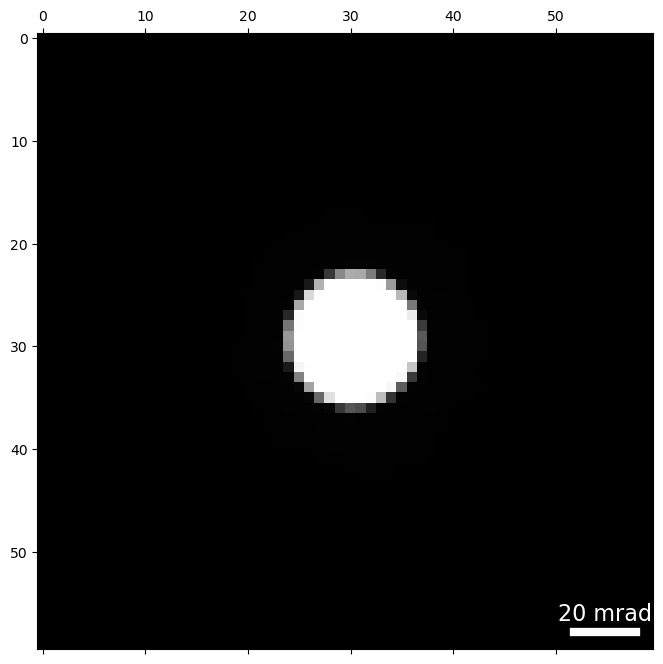

In [4]:
# Calculate the mean diffraction pattern
dataset.get_dp_mean();

# plot the mean diffraction pattern and vacuum probe measurement
py4DSTEM.show(
    dataset.tree('dp_mean'),
)

The center beam is very bright, but this dataset contains much higher scattering angles. To see both the high intensity and low intensity regions of the mean diffraction pattern, we can use logarithmic intensity scaling:

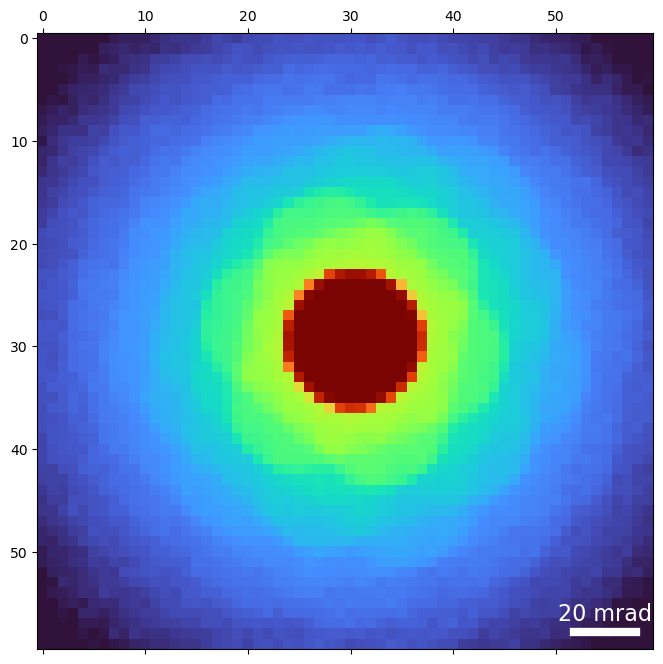

In [5]:
py4DSTEM.show(
    dataset.tree('dp_mean'),
    scaling = 'log',
    cmap = 'turbo',
)

Note also that we already have a dimensioned scalebar - this dataset has already had the pixel size calibration added in real and diffraction space.

# Virtual images

In [6]:
# Get probe radius in pixels
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(plot = False)

100%|█████████████████████████████████████████████████████████████| 6120/6120 [00:00<00:00, 117071.16it/s]


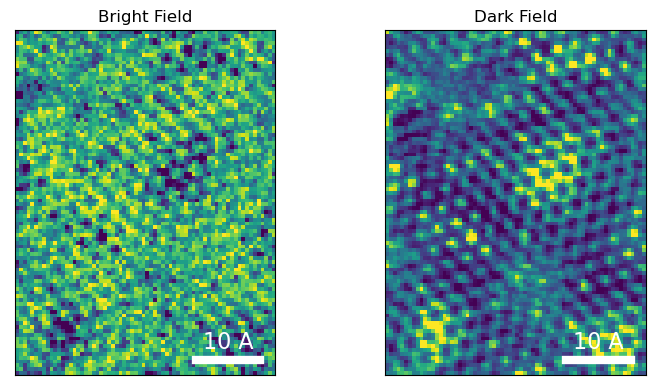

In [7]:
# Make a virtual bright field and dark field image
expand_BF = 2.0  # expand radius by 2 pixels to encompass the full center disk

center = (probe_qx0, probe_qy0)
radius_BF = probe_radius_pixels + expand_BF
radii_DF = (probe_radius_pixels + expand_BF, 1e3)

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
    shift_center = False,
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
    shift_center = False,
);

# plot the virtual images
py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),               
    ],
    cmap='viridis',
    ticks = False,
    axsize=(4,4),
    title=['Bright Field','Dark Field'],
)

As we can see, this sample consists of a twisted bilayer of MoS2 which form a moire lattice. When the 2 lattices are aligned, we get brighter atomic columns in the dark field image.  When they are misaligned, we see lower contrast.

# Differential Phase Contrast (DPC)

In DPC, we measure the center of mass (CoM) of the electron probe in diffraction space for each probe position. This CoM corresponds to the average in-plane momentum of the electron beam, which is proportional to the electic field. In matter, the electric field is the derivative of the sample's electrostatic potential, which in turn is proportional to the sample's phase shift. Hence if we numerically integrate the signal, we can reconstruct the phase.

Best fit rotation = 28.0 degrees.
No need to transpose diffraction intensities.


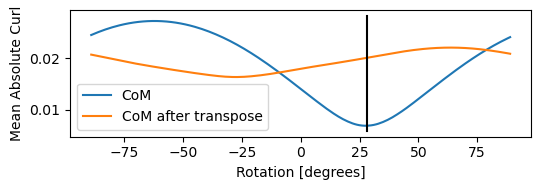

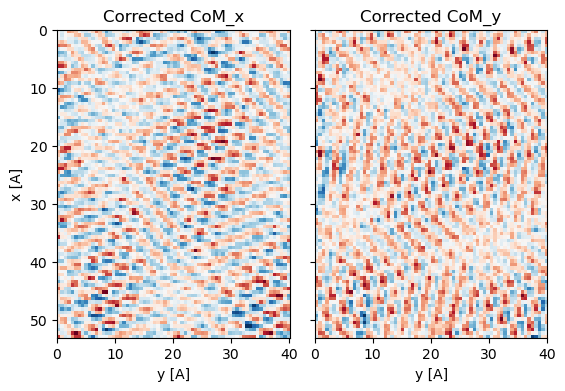

In [8]:
# Initialize the DPC reconstruction
dpc = py4DSTEM.process.phase.DPCReconstruction(
    datacube=dataset,
    energy = 300e3,
).preprocess()

We first estimate the relative rotation between the real space scanning coordinate system and the diffraction space detector coordinates. This value can be non-zero if the STEM scan coils are rotated to some angle, if the detector is rotated around the optical axis, or if the data has been read incorrectly (transposing x and y or kx and ky for example).

Reconstructing phase: 100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 400.48 iter/s]
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_dpc.py:897: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  spec.tight_layout(fig)


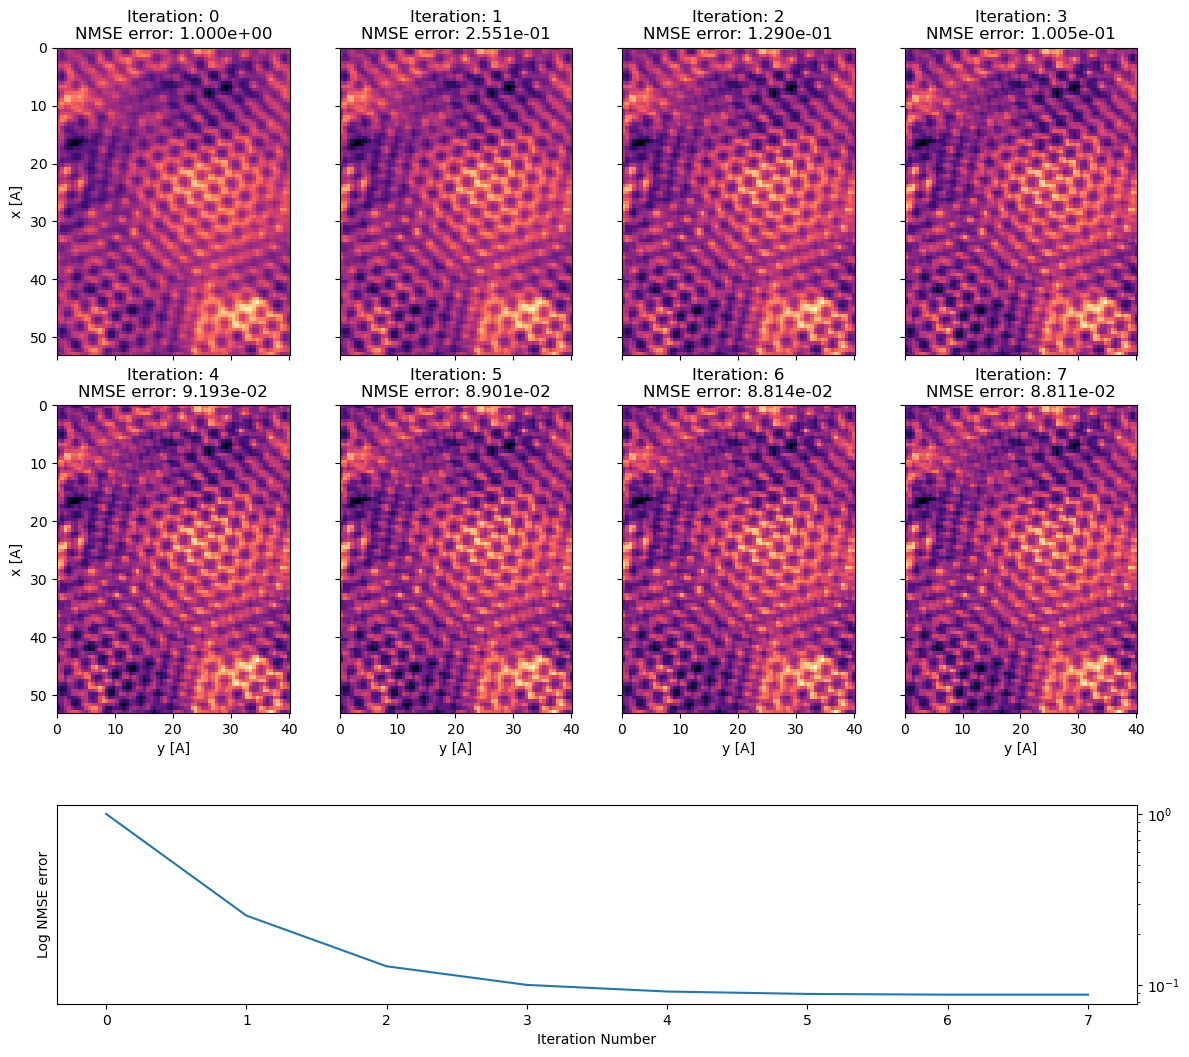

In [9]:
dpc.reconstruct(
    max_iter=8,
    store_iterations=True,
    reset=True,
).visualize(
    figsize=(12,11),
    iterations_grid='auto',
);

We see that the lattice image is somewhat sharper, and has a higher signal to noise. This is because phase contrast imaging methods such as DPC reconstructions are more dose-efficient than bright field or dark field imaging for thin samples. However the resolution is still limited to the STEM probe sampling density.

# Parallax Depth Sectioning

Each pixel in diffraction space can be used to form a virtual image.  On the bright field disk, each of these pixels represents a plane wave of electrons which impacted the sample at a different angle, and because the probe is defocused, a different position on the sample surface. We can computationally align each of these images by using the "parallax operator." This operator corrects the geometric intercepts of each virtual image to be properly focused by aligning the virtual images. The final step is to correct the defocus either by solving the full complex wave (S-matrix reconstruction) or assuming a weak phase object and using contrast transfer function (CTF)-correction.

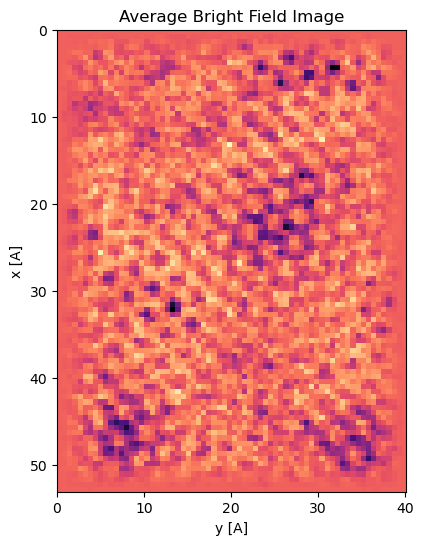

In [10]:
# initialize the reconstruction class
parallax = py4DSTEM.process.phase.ParallaxReconstruction(
    datacube=dataset,
    energy = 80e3,
    object_padding_px=(16,16),
    # device = "gpu", 
    verbose = True
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=8,
)

Alignment at bin 2: 100%|████████████████████████████████████| 39/39 [00:00<00:00, 603.44 image subsets/s]


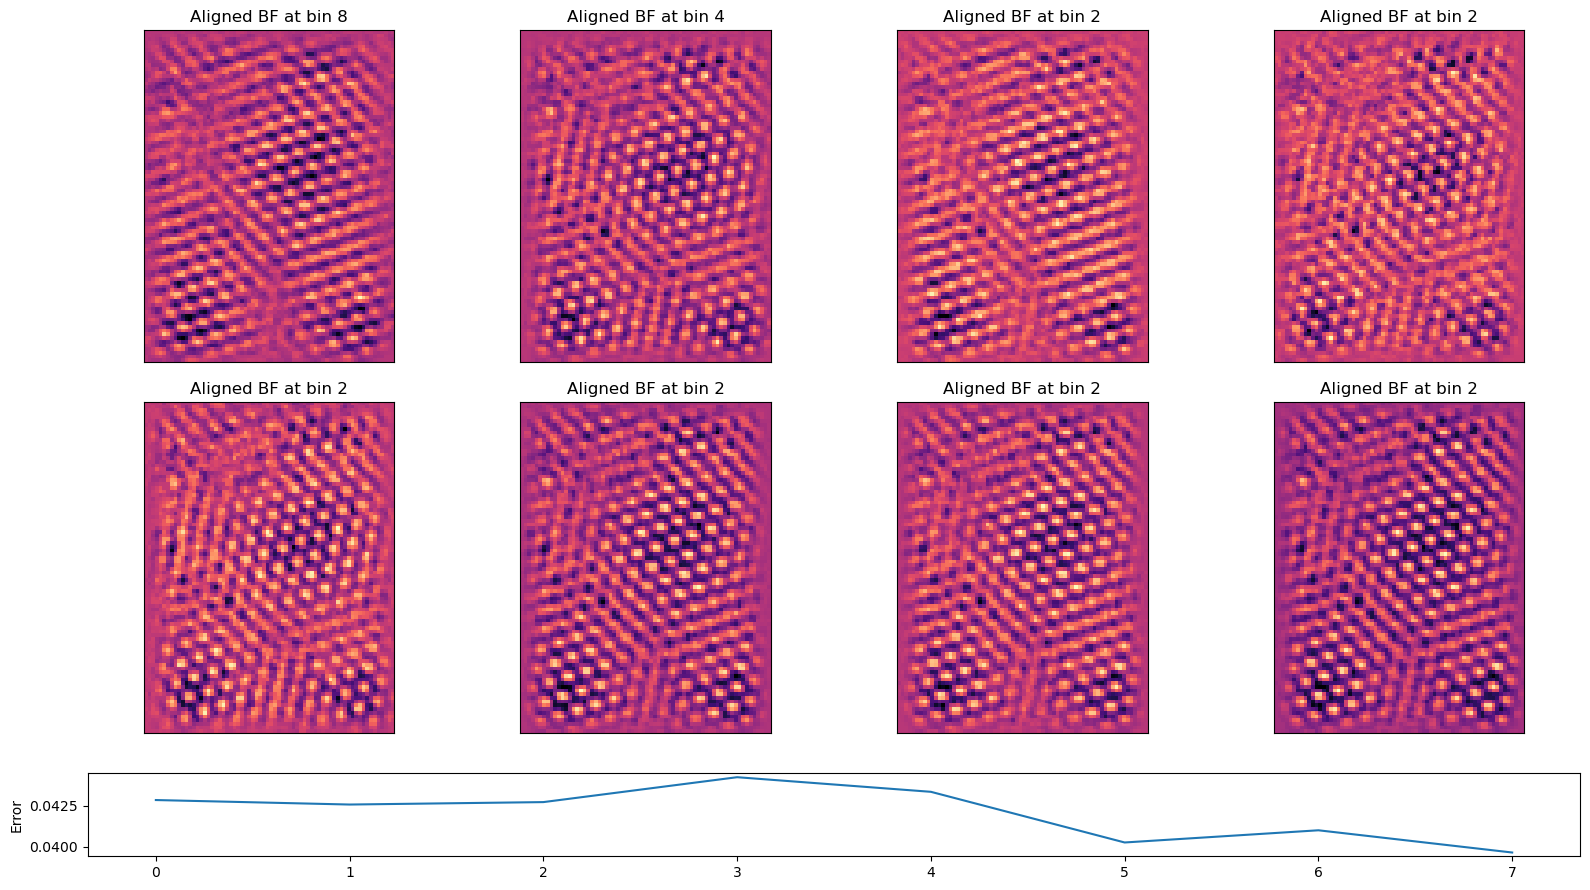

In [11]:
parallax = parallax.reconstruct(
    reset=True,
    regularizer_matrix_size=(1,1),
    regularize_shifts=True,
    running_average=True,
    min_alignment_bin = 2,
    max_iter_at_min_bin = 6,
)

The tilt-shift parallax correction has brought the sum of all images into focus. We next try the CTF-correction method to reconstruct the object phase.

Rotation of Q w.r.t. R = 26.925 deg
Astigmatism (A1x,A1y)  = (-19,2) Ang
Aberration C1          = -49 Ang
Defocus dF             =  49 Ang


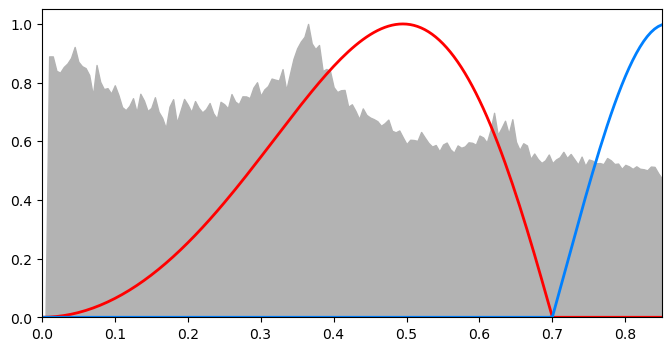

In [12]:
parallax.aberration_fit(
    plot_CTF_compare = True,
)

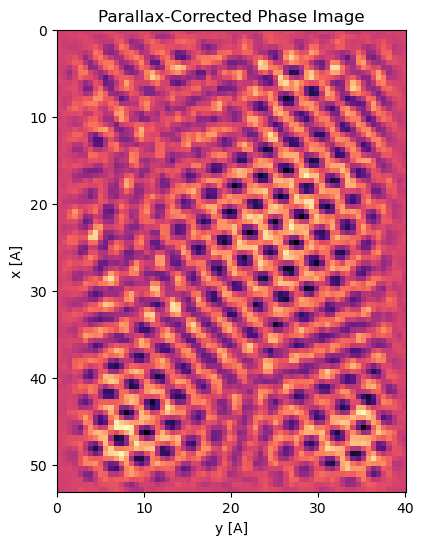

In [13]:
parallax.aberration_correct()

# Ptychography

To reconstruct the complex object wave including both amplitude and phase, while simultaneously solving for the probe aberrations and deconvolving the probe, we will use ptychography. Notes:
- We get the probe convergence semiangle from the pixel size and estimated radius in pixels
- We use the rotation estimate from the previous parallax measurement.
- We use the initial defocus estimate from the previous parallax measurement.

In [19]:
# Get the probe convergence semiangle from the pixel size and estimated radius in pixels
semiangle_cutoff = dataset.calibration.get_Q_pixel_size() * probe_radius_pixels
print('semiangle cutoff estimate = ' + str(np.round(semiangle_cutoff,decimals=1)) + ' mrads')

# Get the estimated defocus from the parallax reconstruction - note that defocus dF has the opposite sign as the C1 aberration!
defocus = -parallax.aberration_C1
print('estimated defocus         = ' + str(np.round(defocus)) + ' Angstroms')

rotation_degrees = np.rad2deg(parallax.rotation_Q_to_R_rads)
print('estimated rotation        = ' + str(np.round(rotation_degrees)) + ' deg')

semiangle cutoff estimate = 21.4 mrads
estimated defocus         = 49.0 Angstroms
estimated rotation        = 27.0 deg


/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:527: UserWarning: Best fit rotation forced to 30 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:541: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


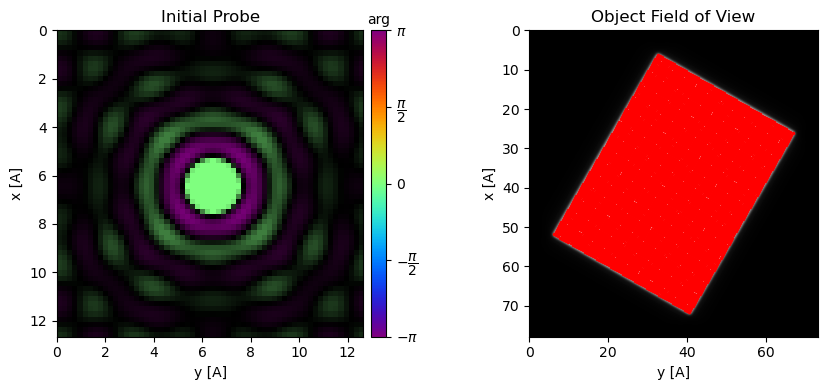

In [24]:
# Preprocessing - recall the accelerating voltage is 80 kV
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    device = 'gpu',
    energy = 80e3,
    semiangle_cutoff = semiangle_cutoff,
    #defocus = defocus,
    object_type='potential',
).preprocess(
    plot_center_of_mass = False, 
    plot_rotation = False, 
    plot_probe_overlaps = True, 
    #force_com_rotation = rotation_degrees,
    force_com_rotation = 30,
    force_com_transpose = False,
    fit_function = "constant",
)

Performing 16 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.0.


Reconstructing object and probe: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 19.15 iter/s]


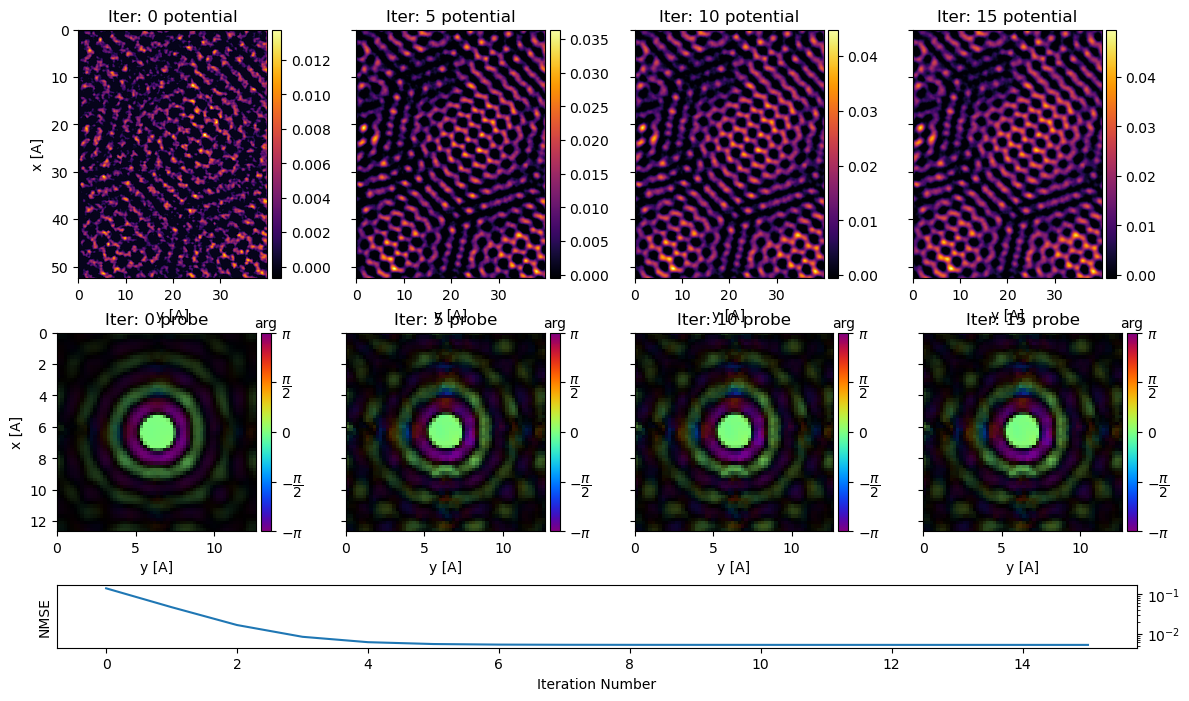

In [25]:
ptycho = ptycho.reconstruct(
    reset = True,
    store_iterations = True,
    max_iter = 16,
    step_size = 0.5,
    gaussian_filter_sigma = 0.75,
    normalization_min=1.0,
).visualize(
    iterations_grid='auto',
    #figsize=(12,8),
)

# Comparison

Now let's compare the different imaging methods side-by-side!

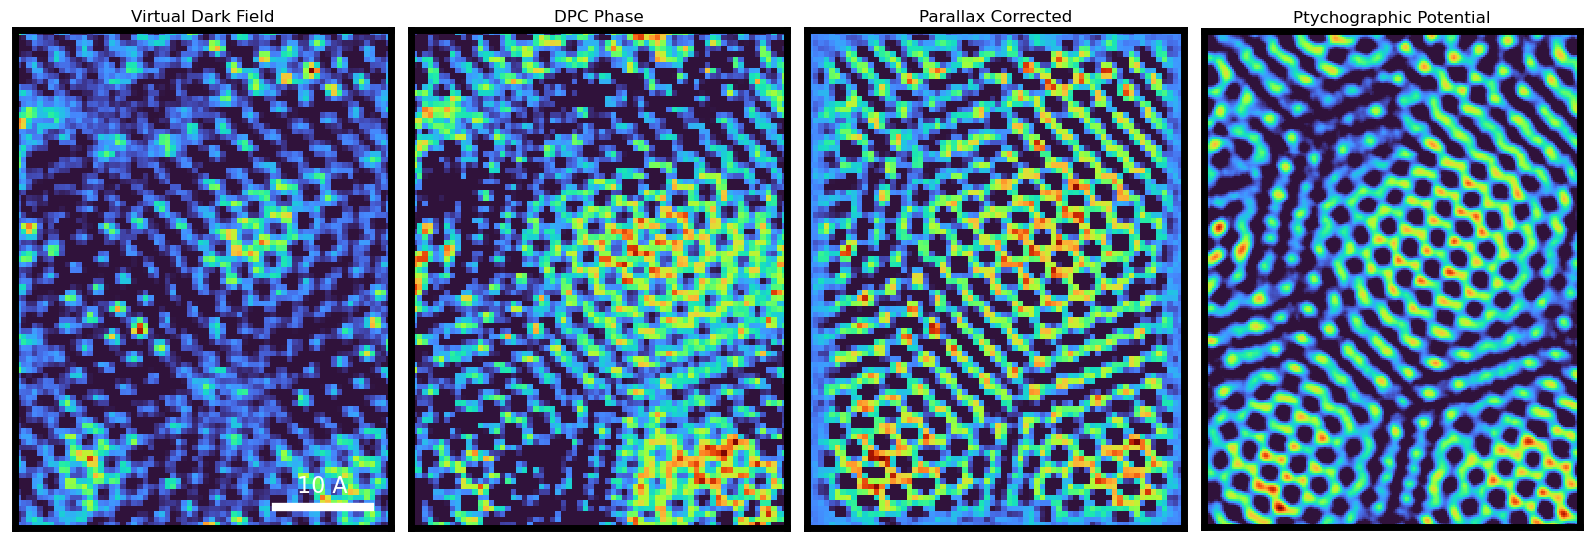

In [27]:
p = parallax._object_padding_px
obj = ptycho._crop_rotate_object_fov(ptycho.object, padding=0)

py4DSTEM.show(
    [
        dataset.tree('dark_field'),               
        dpc.object_phase,
        parallax.recon_phase_corrected[p[0]//2:-p[0]//2,p[1]//2:-p[1]//2],
        obj,
    ],
    vmin = 0.25,
    vmax = 1,
    ticks = False,
    cmap = 'turbo',
    axsize = (4,6),
    title = [
        'Virtual Dark Field',
        'DPC Phase',
        'Parallax Corrected',
        'Ptychographic Potential',
    ],
    bordercolor = 'k',
)